# Predicting on CENSO samples.

In [1]:
### IMPORTANTE ELEGIR ANIOS
startyr = 2013
endyr = 2022

In [2]:
# Load modules
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from IPython.core.display import display, HTML

import pickle
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os

In [3]:
# Column names
y_cols = ['CAT_OCUP', 'P47T', 'PP10E', 'PP10D', 'PP07K', 'PP07I', 'V3_M', 'PP07G4', 'CH16', 'T_VI', 
          'V12_M', 'TOT_P12', 'PP07G3', 'V5_M', 'PP07H', 'V2_M', 'PP10C', 
          'PP08D1', 'PP07J', 'CAT_INAC', 'CH07', 'CH08', 'P21', 'PP07G1', 'PP07G_59', 'PP07G2']


x_cols = ['IX_TOT', 'P02', 'P03', 'AGLO_rk', 'Reg_rk', 'V01', 'H05', 'H06',
       'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H16', 'H15', 'PROP', 'H14',
       'H13', 'P07', 'P08', 'P09', 'P10', 'P05', 'CONDACT']

x_cols1 = x_cols
predecir1 = ['CAT_OCUP', 'CAT_INAC', 'CH07']

x_cols2 = x_cols1 + predecir1
predecir2 = ['INGRESO', 'INGRESO_NLB', 'INGRESO_JUB', 'INGRESO_SBS']

x_cols3 = x_cols2 + predecir2
# La seccion PP07G pregunta si el trabajo es en blanco y que beneficios tiene. Puede ayudar a la regresion para ingresos.
# predecir3 = ['PP07G1', 'PP07G2', 'PP07G3', 'PP07G4', 'PP07G_59', 'PP07H', 'PP07I', 'PP07J', 'PP07K']
predecir3 = ['PP07G1','PP07G_59', 'PP07I', 'PP07J', 'PP07K']

# Columnas de ingresos. Necesitan una regresion...
columnas_pesos = [u'P21', u'P47T', u'PP08D1', u'TOT_P12', u'T_VI', u'V12_M', u'V2_M', u'V3_M', u'V5_M']
# P21: INGRESO DE LA OCUPACIÓN PRINCIPAL 
# P47T: TOTAL (laboral y no laboral)
# PP08D1: Sueldos, jornales, etc.
# TOT_P12: TOTAL DE INGRESO  POR  OTRAS OCUPACIONES (Secundaria, previa...)
# T_VI: TOTAL DE INGRESOS NO LABORALES
# V12_M:  CUOTAS DE ALIMENTOS O AYUDA EN DINERO  DE PERSONAS QUE NO VIVEN EN EL HOGAR 
# V2_M: ingreso por JUBILACION O PENSION
# V3_M: INDEMNIZACION POR DESPIDO 
# V5_M: SUBSIDIO  O AYUDA SOCIAL DEL GOBIERNO, IGLESIAS, ETC.

x_cols4 = x_cols3 + predecir3
# Columnas de ingresos. Necesitan una regresion...
predecir4 = columnas_pesos
y_cols4 = predecir4

### Load info

In [4]:
# 0     26271
# 33     9813
# 32     3553
# 13     1643
# 4      1309
# 10     1014
# 2       984
# 34      853

# radio_ref.AGLOMERADO.value_counts()
# 0     25962
# 33     9944
# 32     3553
# 13     1649
# 4      1323
# 10     1017
# 2       997
# 34      844

In [5]:
radio_ref = pd.read_csv('./../data/info/radio_ref.csv')

radio_AGLO = pd.read_csv('https://raw.githubusercontent.com/matuteiglesias/Aglomerados-EPH-INDEC/main/result/radios_aglo_EPH.csv')
radio_AGLO['radio'] = radio_AGLO.COD_2010.str.replace('XX', '99').astype(int)
radio_AGLO['AGLOMERADO'] = radio_AGLO.eph_codagl
radio_AGLO['NOMAGLO'] = radio_AGLO.eph_aglome

radio_ref = radio_ref.drop(['AGLOMERADO'], axis = 1).merge(radio_AGLO[['radio','AGLOMERADO', 'NOMAGLO']], how = 'left')
radio_ref['AGLOMERADO'] = radio_ref['AGLOMERADO'].fillna(0).astype(int)

# radio_ref[['PROV','NOMPROV','DPTO', 'NOMDPTO']].drop_duplicates().to_csv('./../data/DPTO_PROV.csv', index = False)
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
radio_ref = radio_ref.merge(dpto_region)

AGLO_rk = pd.read_csv('./../data/info/AGLO_rk')
Reg_rk = pd.read_csv('./../data/info/Reg_rk')

In [6]:
# ### TESTEO DEFINICION VIEJA DE AGLOS

# radio_ref = pd.read_csv('./../data/info/radio_ref.csv').rename(columns = {'AGLOMERADO': 'AGLOMERADO_'})

# radio_AGLO = pd.read_csv('https://raw.githubusercontent.com/matuteiglesias/Aglomerados-EPH-INDEC/main/result/radios_aglo_EPH.csv')
# radio_AGLO['radio'] = radio_AGLO.COD_2010.str.replace('XX', '99').astype(int)
# radio_AGLO['AGLOMERADO'] = radio_AGLO.eph_codagl
# radio_AGLO['NOMAGLO'] = radio_AGLO.eph_aglome

# # radio_ref = radio_ref.drop(['AGLOMERADO'], axis = 1).merge(radio_AGLO[['radio','AGLOMERADO', 'NOMAGLO']], how = 'left')
# radio_ref = radio_ref.merge(radio_AGLO[['radio','AGLOMERADO', 'NOMAGLO']], how = 'left')
# radio_ref['AGLOMERADO'] = radio_ref['AGLOMERADO'].fillna(0).astype(int)
# radio_ref['NOMAGLO'] = radio_ref['NOMAGLO'].fillna('Fuera de Aglom')


# P02 = pd.read_csv('/home/miglesia/repositories/CensoARG_20102/Preguntas/PERSONA-P02.csv', encoding = 'latin-1')[['radio', 'TOTAL']]
# # P02

# poblacion = radio_ref.merge(P02)
# tabla = poblacion.groupby(['AGLOMERADO', 'NOMAGLO', 'AGLOMERADO_'])[['TOTAL']].sum()#.unstack().fillna('')
# tabla.to_csv('./../data/info/testeo_AGLOS.csv')

In [7]:
frac = 0.01

,desoc,censo2010_ratio
Q,,
2020-08-15,11.700000,1.602740
2020-11-15,10.957932,1.501087
2021-02-15,10.200000,1.397260
2021-05-15,9.600903,1.315192
2021-08-15,8.200000,1.123288


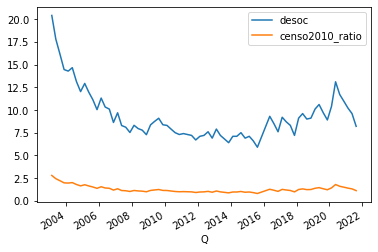

In [8]:
empleo = pd.read_csv('./../data/info/empleo_AGLOsi_MinEcon.csv')
empleo.columns = ['Q', 'desoc']
empleo['Q'] = pd.to_datetime(empleo.Q)
empleo = empleo.set_index('Q')
# empleo = empleo.resample('Q').mean().resample('Q').interpolate(method='linear')
empleo['censo2010_ratio'] = (empleo/empleo.loc['2010-11-15'])

empleo.plot(); #plt.xlim(0, 20)
display(empleo.tail())

In [9]:
# X_q = X_censo.copy()
# X_q['Q'] = q
# # desemp_ARG_censo_sample = CONDACT_cnts.loc[2]/(CONDACT_cnts.loc[1] + CONDACT_cnts.loc[2])
# ratio = empleo.loc[pd.to_datetime(q)].censo2010_ratio # ratio respecto a Q4-2010
# n_desempleados_ = ratio*(CONDACT_cnts[1] + CONDACT_cnts[2])*desemp_ARG_censo
# desemp_adic = round(n_desempleados_ - CONDACT_cnts.loc[2]) # Desempleados adicionales

In [10]:
## Traemos la tasa segun el censo 2010, para oct 2010 (6.29 %) y la que tenemos en dato (7.5%)
desoc_C2010 = pd.read_csv('./../../nivel_empleo/info/desoc_AGLOsi_C2010.csv')
tasa_C2010 = desoc_C2010.loc[desoc_C2010.AGLO_si == True]['Tasa desocupacion'].values[0]
tasa_C2010
# tasa_dato = empleo.loc['2010-09-30'].values[0]

# ratio = 100*tasa_C2010/tasa_dato
# ratio

0.0628729377307203

In [11]:
# # desemp_ratio = pd.read_csv('./../../../Desktop/nivel_empleo/unemp_ratio_censo2010.csv', index_col=0)
# desemp_ratio = pd.read_csv('./../data/info/unemp_ratio_censo2010.csv', index_col=0)
# desemp_ratio.index = pd.DatetimeIndex(desemp_ratio.index)
# desemp_ratio.index = desemp_ratio.index - pd.to_timedelta(desemp_ratio.index.day - 15, unit='d') - pd.DateOffset(months=1)
# desemp_ratio.index.name = 'Q'
# desemp_ratio.plot()

# Predicting

In [12]:
import datetime as dt
## Trimestres con ingresos disponibles (depende de disponibilidad de microdatos EPH)
import glob

fuente_modelos = 'encuestador-de-hogares' # 'indice-pobreza-ExactasUBA'
path = '/media/miglesia/Elements/suite/'+fuente_modelos+'/fitted_RF/clf4_' # use your path

allFiles = []
# allFiles += glob.glob(path +'*.sav')
# allqs = [f[-18:-8] for f in allFiles]

allFiles += glob.glob(path +'*')
allqs = [f[-14:-4] for f in allFiles]
print(sorted(allqs)[:10])
print(sorted(allqs)[-10:])

['2003-08-15', '2003-11-15', '2004-02-15', '2004-05-15', '2004-08-15', '2004-11-15', '2005-02-15', '2005-05-15', '2005-08-15', '2005-11-15']
['2018-08-15', '2018-11-15', '2019-02-15', '2019-05-15', '2019-08-15', '2019-11-15', '2020-02-15', '2020-05-15', '2020-08-15', '2020-11-15']


In [13]:
import gc
import joblib

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Eg. Get a sorted list of the objects and their sizes
# def mem_prof():
#     result = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
#     return result

if not os.path.exists('./../data/yr_samples'):
    os.makedirs('./../data/yr_samples')

### Classification 1
Columnas ['CAT_OCUP', 'CAT_INAC', 'CH07']

### Classification 2
Columna INGRESO

### Classification 3
Columnas ['PP07G1', 'PP07G2', 'PP07G3', 'PP07G4', 'PP07G_59', 'PP07H', 'PP07I', 'PP07J', 'PP07K']

### Regresion

In [14]:
1174037/(18645609 + 1174037)

0.059236022681737104

In [15]:
import json

In [16]:
startyr = 2013
endyr = 2022

In [17]:
y_cols1 = predecir1
y_cols2 = predecir2
y_cols3 = predecir3

In [18]:

for yr in [str(s) for s in range(startyr, endyr)]:
    print(yr)
        
#     file_ = './../data/yr_samples/sample_censo_table_f0.02_'+yr+'_ARG.csv'
#     file_ = '/media/miglesia/Elements/CENSO_dirs/extracted_/yr_samples/sample_censo_table_f0.02_'+yr+'_ARG.csv'
#     file_ = '/media/miglesia/Elements/suite/yr_samples/sample_censo_table_f0.02_'+yr+'_ARG.csv'
    file_ = '/media/miglesia/Elements/suite/yr_samples/table_f'+str(frac)+'_'+yr+'_ARG.csv'


    X_censo = pd.read_csv(file_, usecols = ['DPTO','RADIO_REF_ID','PERSONA_REF_ID', 'HOGAR_REF_ID','IX_TOT_', 'P02', 'P03', 'CONDACT', 'AGLOMERADO', 'URP', 'V01', 'H05', 'H06',
           'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H16', 'H15', 'PROP', 'H14',
           'H13', 'P07', 'P08', 'P09', 'P10', 'P05']).fillna(0)
    X_censo = X_censo.rename(columns = {'IX_TOT_': 'IX_TOT'}) # temporal fix for a typo in samplear.py
#       DPTO_Region = radio_ref[['DPTO', 'Region']].drop_duplicates()
    X_censo = X_censo.merge(dpto_region[['DPTO', 'Region']])
#     print(X_censo.merge(radio_ref[['RADIO_REF_ID', 'PROV']], how = 'left')['PROV'].nunique())
    X_censo = X_censo.merge(AGLO_rk[['AGLOMERADO', 'AGLO_rk']]).merge(Reg_rk[['Region', 'Reg_rk']])
    

    ## Tratamiento trimestral 
    
#     qs = pd.read_csv('./../data/training/EPHARG_train_'+yr[2:]+'.csv', usecols=['Q'])
#     qs = pd.date_range(start = dt.datetime(int(yr),3,31), end = dt.datetime(int(yr),12,31), freq='Q').values
    qs = np.array(allqs)[[i for i, si in enumerate(allqs) if si.startswith(yr)]]
    print(qs)
    
    CONDACT_cnts = X_censo.CONDACT.value_counts()
    
    print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])
    
    ### Cargar modelos de la parte no trimestral (anual).

    print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])

    for q in sorted(qs):
        X_q = X_censo.copy()
        X_q['Q'] = q
        print('Nuevo trimestre.')

        # desemp_ARG_censo_sample = CONDACT_cnts.loc[2]/(CONDACT_cnts.loc[1] + CONDACT_cnts.loc[2])
        
        ratio = empleo.loc[pd.to_datetime(q)].censo2010_ratio
        n_desempleados_ = ratio*(CONDACT_cnts[1] + CONDACT_cnts[2])*tasa_C2010
        desemp_adic = round(n_desempleados_ - CONDACT_cnts.loc[2]) # Desempleados adicionales
        
        print(str(q)[:10])
#         print(desemp_adic)

        if desemp_adic > 0:
            X_q.loc[
                X_q.query('CONDACT == 1').sample(desemp_adic).index,
                'CONDACT'
            ] = 2
        elif desemp_adic < 0:
            X_q.loc[
                X_q.query('CONDACT == 2').sample(- desemp_adic).index,
                'CONDACT'
            ] = 1

        desempleo = X_q.CONDACT.value_counts().loc[2] / (X_q.CONDACT.value_counts().loc[1] + X_q.CONDACT.value_counts().loc[2])
        print('desempleo:' + str(desempleo))
        
#         print('/media/miglesia/Elements/suite/'+fuente_modelos+'/fitted_RF/clf1_0.02_'+yr+'_ARG')
#         break
        

        #################################    #################################    #################################
        print('C1')
        ## CLASIF 1
        data_filename1 = './../data/yr_samples/RFC1_'+str(frac)+'_'+str(q)[:10]+'_ARG.csv'
        if not os.path.exists(data_filename1):
            model_filename1 = '/home/miglesia/repositories/encuestador-de-hogares/fitted_RF/clf1_'+yr+'_ARG'
            # clf1 = pickle.load(open(model_filename1+'.sav', 'rb'))
            clf1 = joblib.load(model_filename1)

#             y_out1 = clf1.predict(X_q[x_cols1].values)
#             y_censo_fit1 = pd.DataFrame(y_out1, index = X_q.index, columns=predecir1)

            ## Prediccion usando predict proba y factores de balance.
            y_out1 = pd.DataFrame([])
            proba_values = clf1.predict_proba(X_q[x_cols1])

            ## Leer factores de archivo json
            tag = 'clf1_'+yr+'_ARG'
            with open('/home/miglesia/repositories/encuestador-de-hogares/data/training/factors/'+tag+'.json', 'r') as file:
                info = json.load(file)
            factors_mean = pd.DataFrame(json.loads(info[tag])).stack()
            factors_mean.index.names = ['variable', 'valor']
            factors_mean.index = factors_mean.index.set_levels(factors_mean.index.levels[1].astype(float).astype(int), level='valor')

            for j, y_col in enumerate(y_cols1):
#                 y_probas = pd.DataFrame(proba_values[j], columns = sorted(y_[y_col].unique()))
                y_probas = pd.DataFrame(proba_values[j], columns = factors_mean.loc[y_col].index.values)
                y_out1[y_col] = (y_probas/factors_mean.loc[y_col]).idxmax(1)#.value_counts().sort_index()

            ## Listo
            y_censo_fit1 = pd.DataFrame(y_out1, index = X_q.index, columns=predecir1)

            Xy1_censo = pd.concat([X_q, y_censo_fit1], axis = 1)

#             save
            Xy1_censo.to_csv(data_filename1, index = False)
    
            del X_q; del Xy1_censo; del clf1
            gc.collect()

        print('C2')
        ## CLASIF 2
        data_filename2 = './../data/yr_samples/RFC2_'+str(frac)+'_'+str(q)[:10]+'_ARG.csv'
        if not os.path.exists(data_filename2):
            model_filename2 = '/home/miglesia/repositories/encuestador-de-hogares/fitted_RF/clf2_'+yr+'_ARG'
            #         filename = '/media/miglesia/Elements/CENSO_dirs/Pobreza/fitted_RF/clf2_0.02_'+yr+'_ARG.sav'
            clf2 = joblib.load(model_filename2)
            # clf2 = pickle.load(open(model_filename2+'.sav', 'rb'))
    
            Xy1_censo = pd.read_csv(data_filename1)
        
            ## Prediccion sin balance
#                     y_out2 = clf2.predict(Xy1_censo[x_cols2].values)

            ## Prediccion usando predict proba y factores de balance.
            y_out2 = pd.DataFrame([])
            proba_values = clf2.predict_proba(Xy1_censo[x_cols2])

            ## Leer factores de archivo json
            tag = 'clf2_'+yr+'_ARG'
            with open('/home/miglesia/repositories/encuestador-de-hogares/data/training/factors/'+tag+'.json', 'r') as file:
                info = json.load(file)
            factors_mean = pd.DataFrame(json.loads(info[tag])).stack()
            factors_mean.index.names = ['variable', 'valor']
            factors_mean.index = factors_mean.index.set_levels(factors_mean.index.levels[1].astype(float).astype(int), level='valor')

            for j, y_col in enumerate(y_cols2):
#                 y_probas = pd.DataFrame(proba_values[j], columns = sorted(y_[y_col].unique()))
                y_probas = pd.DataFrame(proba_values[j], columns = factors_mean.loc[y_col].index.values)
                y_out2[y_col] = (y_probas/factors_mean.loc[y_col]).idxmax(1)#.value_counts().sort_index()

            ## Listo
            y_censo_fit2 = pd.DataFrame(y_out2, index = Xy1_censo.index, columns=predecir2)
            
            Xy2_censo = pd.concat([Xy1_censo, y_censo_fit2], axis = 1)

#             save
            Xy2_censo.to_csv(data_filename2, index = False)
            del Xy2_censo; del clf2
            gc.collect()
        print('C3')

        ## CLASIF 3
        data_filename3 = './../data/yr_samples/RFC3_'+str(frac)+'_'+str(q)[:10]+'_ARG.csv'
        if not os.path.exists(data_filename3):
            model_filename3 = '/home/miglesia/repositories/encuestador-de-hogares/fitted_RF/clf3_'+yr+'_ARG'
            #         filename = '/media/miglesia/Elements/CENSO_dirs/Pobreza/fitted_RF/clf3_0.02_'+yr+'_ARG.sav'
            clf3 = joblib.load(model_filename3)
            # clf3 = pickle.load(open(model_filename3+'.sav', 'rb'))

            Xy2_censo = pd.read_csv(data_filename2)
            
                        ## Prediccion sin balance
#             y_out3 = clf3.predict(Xy2_censo[x_cols3].values)

            ## Prediccion usando predict proba y factores de balance.
            y_out3 = pd.DataFrame([])
            proba_values = clf3.predict_proba(Xy2_censo[x_cols3])

            ## Leer factores de archivo json
            tag = 'clf3_'+yr+'_ARG'
            with open('/home/miglesia/repositories/encuestador-de-hogares/data/training/factors/'+tag+'.json', 'r') as file:
                info = json.load(file)
            factors_mean = pd.DataFrame(json.loads(info[tag])).stack()
            factors_mean.index.names = ['variable', 'valor']
            factors_mean.index = factors_mean.index.set_levels(factors_mean.index.levels[1].astype(float).astype(int), level='valor')

            for j, y_col in enumerate(y_cols3):
#                 y_probas = pd.DataFrame(proba_values[j], columns = sorted(y_[y_col].unique()))
                y_probas = pd.DataFrame(proba_values[j], columns = factors_mean.loc[y_col].index.values)
                y_out3[y_col] = (y_probas/factors_mean.loc[y_col]).idxmax(1)#.value_counts().sort_index()

            ## Listo
            y_censo_fit3 = pd.DataFrame(y_out3, index = Xy2_censo.index, columns=predecir3)

            Xy3_censo = pd.concat([Xy2_censo, y_censo_fit3], axis = 1)
#             save
            Xy3_censo.to_csv(data_filename3, index = False)

            del Xy3_censo; del clf3
            gc.collect()
            
            
        print('reg')
        # REGRESION            
        data_filename4 = './../data/yr_samples/RFReg_'+str(frac)+'_'+str(q)[:10]+'_ARG.csv'
        if not os.path.exists(data_filename4):

            ## Cargar Modelo
            model_filename4 = '/home/miglesia/repositories/encuestador-de-hogares/fitted_RF/clf4_'+str(q)[:10]+'_ARG'
    #         filename = '/media/miglesia/Elements/CENSO_dirs/Pobreza/fitted_RF/clf4_0.02_'+str(q)[:10]+'_ARG.sav'
#             clf4 = pickle.load(open(model_filename4+'sav', 'rb'))
            clf4 = joblib.load(model_filename4)

            Xy3_censo = pd.read_csv(data_filename3)
            y_out4 = clf4.predict(Xy3_censo[x_cols4].values); del clf4
            y_censo_fit4 = pd.DataFrame(y_out4, index = Xy3_censo.index, columns=predecir4)

            Xy4_censo = pd.concat([Xy3_censo, y_censo_fit4], axis = 1)
#             save
            Xy4_censo.to_csv(data_filename4, index = False)

            del Xy4_censo;
            gc.collect()
            
        print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])
                    
    del X_censo; #del clf1; del clf2; del clf3


2013
['2013-02-15' '2013-05-15' '2013-08-15' '2013-11-15']
[('X_censo', 134664685), ('radio_ref', 19993974), ('radio_AGLO', 6758930), ('dpto_region', 120394), ('empleo', 3872)]
[('X_censo', 134664685), ('radio_ref', 19993974), ('radio_AGLO', 6758930), ('dpto_region', 120394), ('empleo', 3872)]
Nuevo trimestre.
2013-02-15
desempleo:0.06804227282259362
C1
C2
C3
reg
[('X_q', 192609602), ('X_censo', 151573013), ('radio_ref', 19993974), ('radio_AGLO', 6758930), ('dpto_region', 120394)]
Nuevo trimestre.
2013-05-15
desempleo:0.06200956844461568
C1
C2
C3
reg
[('Xy3_censo', 198914018), ('X_q', 192609602), ('X_censo', 151573013), ('y_censo_fit4', 29844936), ('y_out4', 29844904)]
Nuevo trimestre.
2013-08-15
desempleo:0.05856648898555955
C1
C2
C3
reg
[('Xy3_censo', 198914018), ('X_q', 192609602), ('X_censo', 151573013), ('y_censo_fit4', 29844936), ('y_out4', 29844904)]
Nuevo trimestre.
2013-11-15
desempleo:0.05512340952650342
C1
C2
C3
reg
[('Xy3_censo', 198914018), ('X_q', 192609602), ('X_censo', 